In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  

/home/koosy/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Load them!
cwd = os.getcwd()
loadpath = cwd + "/data/data4vgg.npz"
l = np.load(loadpath)

# See what's in here
l.files

# Parse data
trainimg = l['trainimg']
trainlabel = l['trainlabel']
testimg = l['testimg']
testlabel = l['testlabel']
ntrain = trainimg.shape[0]
nclass = trainlabel.shape[1]
dim    = trainimg.shape[1]
ntest  = testimg.shape[0]

print ("%d train images loaded" % (ntrain))
print ("%d test images loaded" % (ntest))
print ("%d dimensional input" % (dim))
print ("%d classes" % (nclass))

69 train images loaded
18 test images loaded
37632 dimensional input
2 classes


In [3]:
n_input_width = 112
n_input_height = 112
n_input_channel = 3

n_conv1_patch_size = 3 
n_conv1_filter = 64

n_conv2_patch_size = 3 
n_conv2_filter = 64

n_output  = 2 # cat or dog

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input_width * n_input_height * n_input_channel])
y = tf.placeholder(tf.float32, [None, n_output])

wc1 = tf.Variable(tf.random_normal([n_conv1_patch_size, n_conv1_patch_size, n_input_channel, n_conv1_filter], stddev=0.1))
bc1 = tf.Variable(tf.random_normal([n_conv1_filter], stddev=0.1))

wc2 = tf.Variable(tf.random_normal([n_conv2_patch_size, n_conv2_patch_size, n_conv1_filter, n_conv2_filter], stddev=0.1))
bc2 = tf.Variable(tf.random_normal([n_conv2_filter], stddev=0.1))

wf = tf.Variable(tf.random_normal([(n_input_width/4)*(n_input_height/4)*n_conv2_filter, n_output], stddev=0.1))
bf = tf.Variable(tf.random_normal([n_output], stddev=0.1))

# Reshape input
input_r = tf.reshape(x, shape=[-1, n_input_width, n_input_width, n_input_channel])
# Convolution
conv1 = tf.nn.conv2d(input_r, wc1, strides=[1, 1, 1, 1], padding='SAME')
# Add-bias
bias1 = tf.nn.bias_add(conv1, bc1)
# Pass ReLu
relu1 = tf.nn.relu(bias1)
# Max-pooling
pool1  = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Convolution
conv2 = tf.nn.conv2d(pool1, wc2, strides=[1, 1, 1, 1], padding='SAME')
# Add-bias
bias2 = tf.nn.bias_add(conv2, bc2)
# Pass ReLu
relu2 = tf.nn.relu(bias2)
# Max-pooling
pool2  = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Vectorize
dense = tf.reshape(pool2, [-1, wf.get_shape().as_list()[0]])
# Fully-connected layer
out = tf.add(tf.matmul(dense, wf), bf)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(out, y))

In [4]:
# Parameters
learning_rate   = 0.001
training_epochs = 50
batch_size      = 100
display_step    = 10

# Saver 
save_step = 10;
saver = tf.train.Saver(max_to_keep=training_epochs) 

optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
corr = tf.equal(tf.argmax(out,1), tf.argmax(y,1)) # Count corrects
accr = tf.reduce_mean(tf.cast(corr, tf.float32)) # Accuracy

# Do some optimizations
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

# Training cycle
for epoch in range(training_epochs):
    avg_cost = 0.
    num_batch = int(ntrain/batch_size)+1
    # Loop over all batches
    for i in range(num_batch): 
        randidx = np.random.randint(ntrain, size=batch_size)
        batch_xs = trainimg[randidx, :]
        batch_ys = trainlabel[randidx, :]                
        # Fit training using batch data
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys})
        # Compute average loss
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/num_batch

    # Display logs per epoch step
    if epoch % display_step == 0:
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
        train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})
        print (" Training accuracy: %.3f" % (train_acc))
        test_acc = sess.run(accr, feed_dict={x: testimg, y: testlabel})
        print (" Test accuracy: %.3f" % (test_acc))
            
    # Save Net
    if epoch % save_step == 0:
        saver.save(sess, "net/cnn_custom_dataset.ckpt-" + str(epoch))

print ("Optimization Finished!")

Epoch: 000/050 cost: 12.928732872
 Training accuracy: 0.530
 Test accuracy: 0.389
Epoch: 010/050 cost: 2.591102839
 Training accuracy: 0.590
 Test accuracy: 0.389
Epoch: 020/050 cost: 0.336557388
 Training accuracy: 0.890
 Test accuracy: 0.667
Epoch: 030/050 cost: 0.188502848
 Training accuracy: 0.880
 Test accuracy: 0.889
Epoch: 040/050 cost: 0.058078680
 Training accuracy: 1.000
 Test accuracy: 0.833
Optimization Finished!


In [9]:
# Restore trained network
ckpt = tf.train.get_checkpoint_state("net")
if ckpt and ckpt.model_checkpoint_path:
    epoch = 49
    saver.restore(sess, "cnn_mnist.ckpt-" + str(epoch))

In [14]:
conv1_out = sess.run(conv1, feed_dict={x: testimg[0:1, :]})
pool1_out = sess.run(pool1, feed_dict={x: testimg[0:1, :]})
conv2_out = sess.run(conv2, feed_dict={x: testimg[0:1, :]})
pool2_out = sess.run(pool2, feed_dict={x: testimg[0:1, :]})

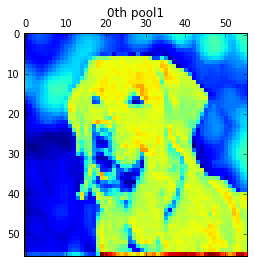

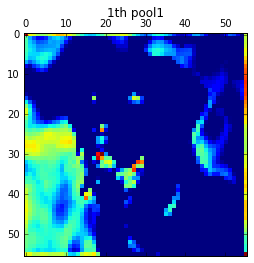

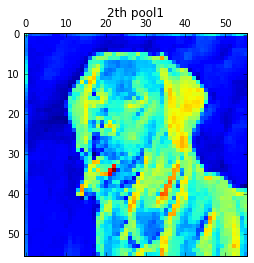

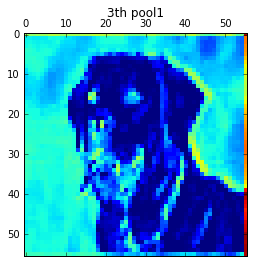

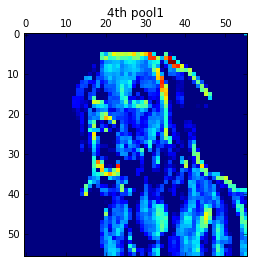

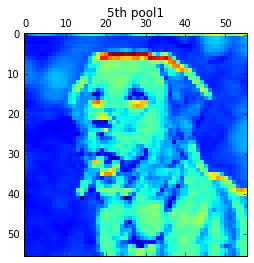

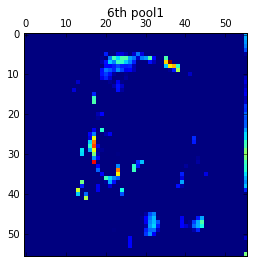

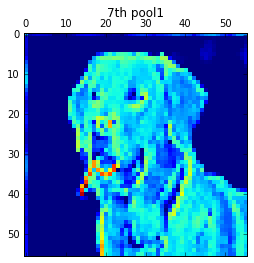

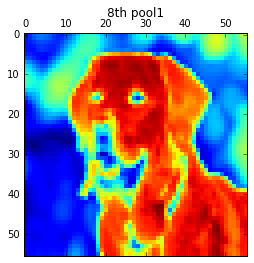

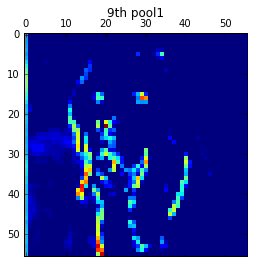

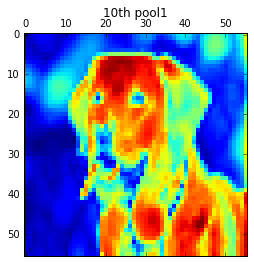

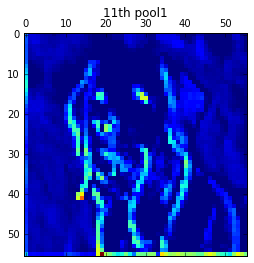

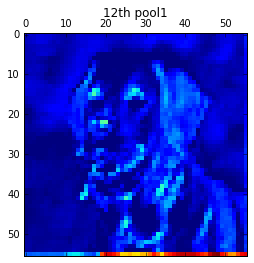

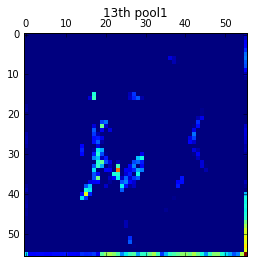

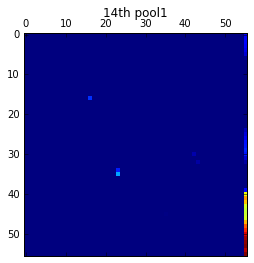

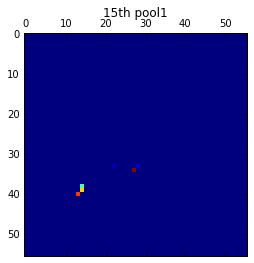

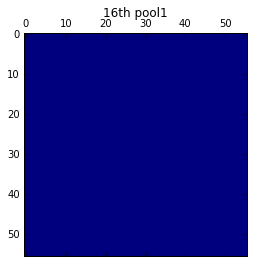

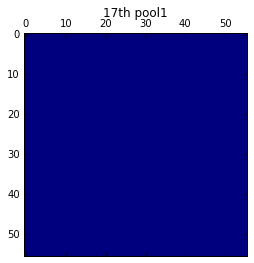

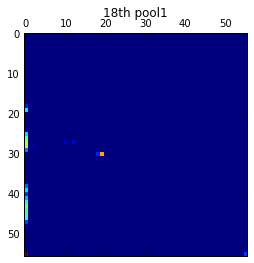

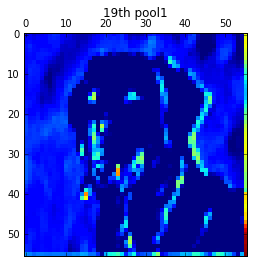

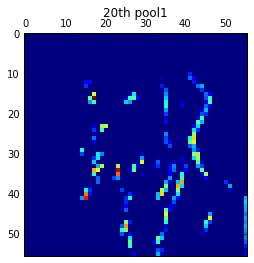

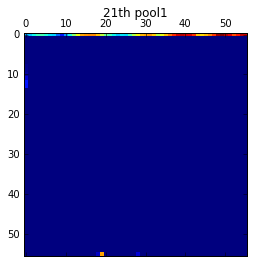

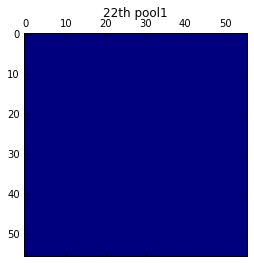

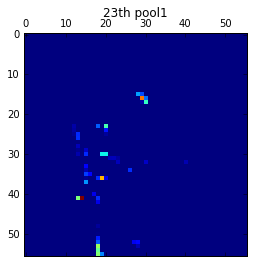

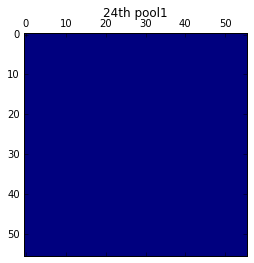

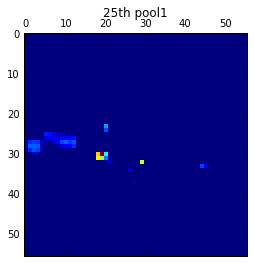

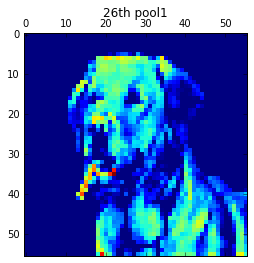

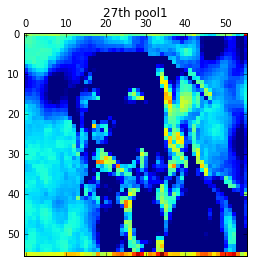

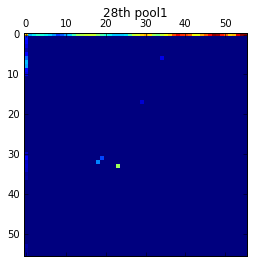

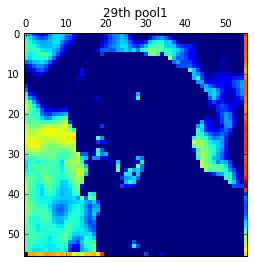

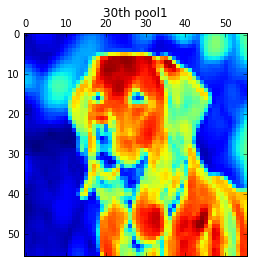

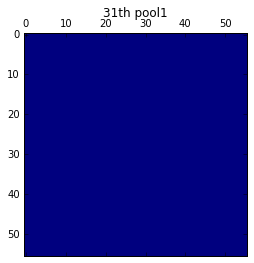

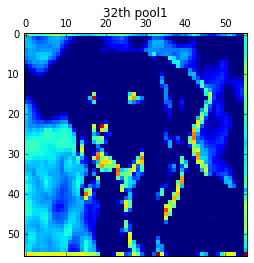

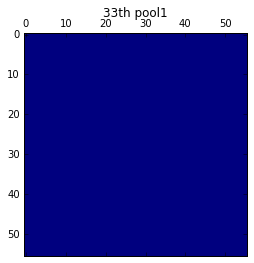

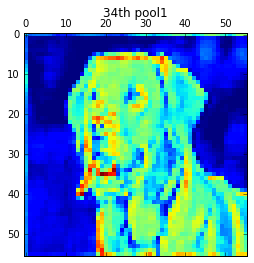

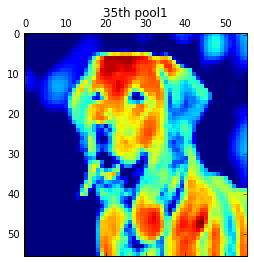

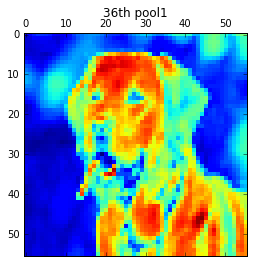

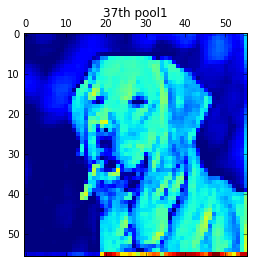

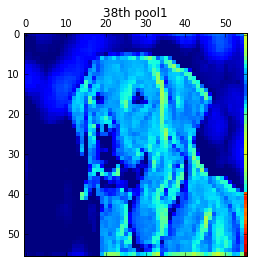

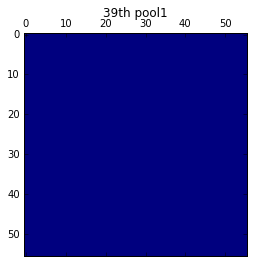

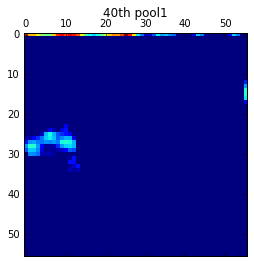

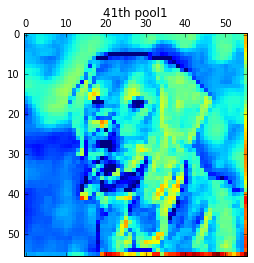

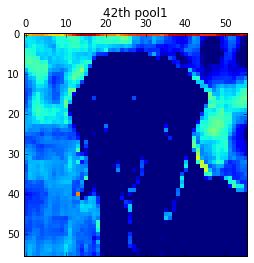

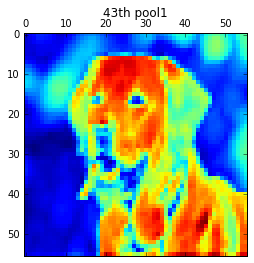

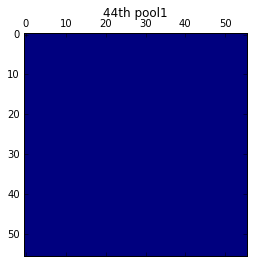

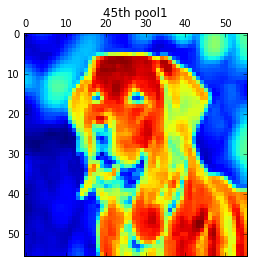

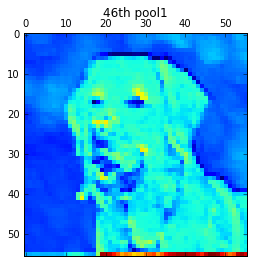

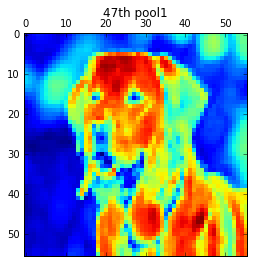

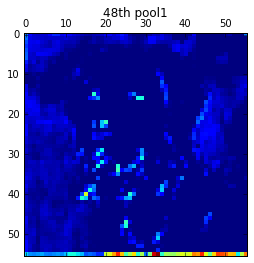

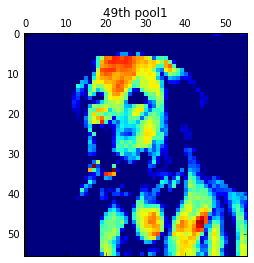

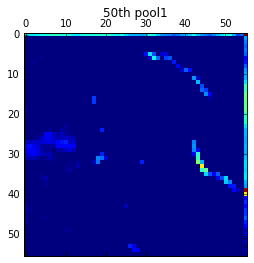

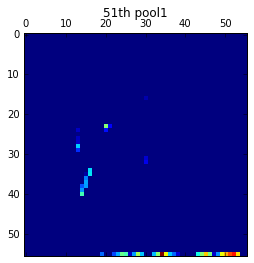

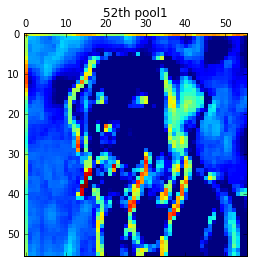

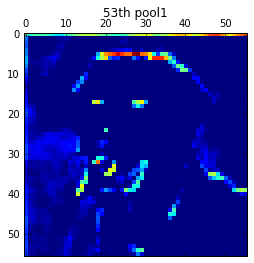

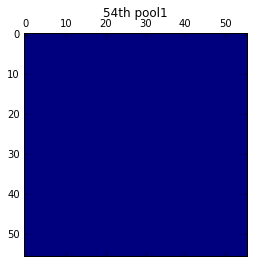

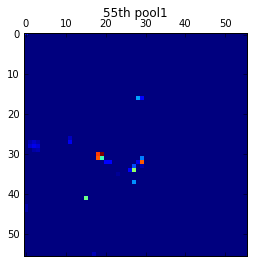

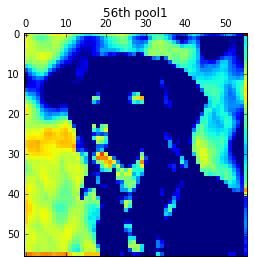

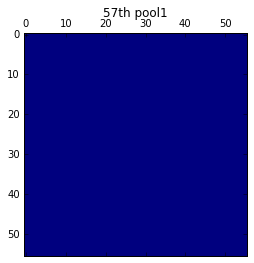

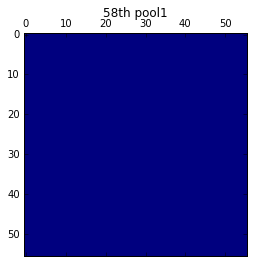

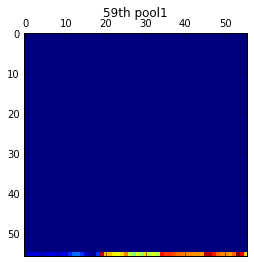

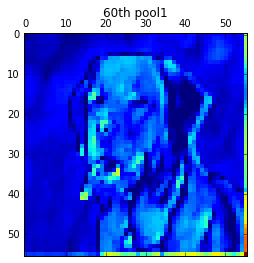

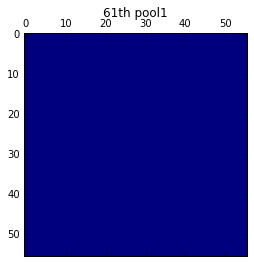

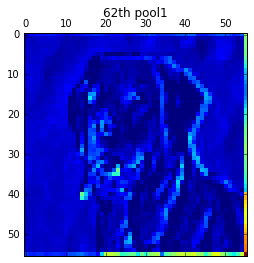

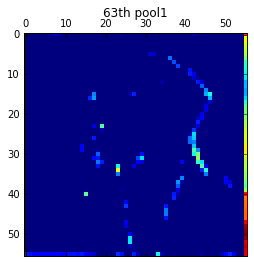

In [25]:
# Plot ! 
for i in range(64):
    plt.matshow(pool1_out[0, :, :, i])
    plt.title(str(i) + "th pool1")
    plt.show() 

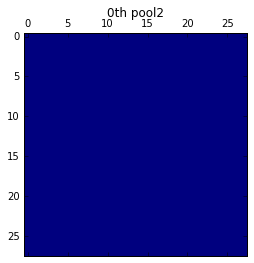

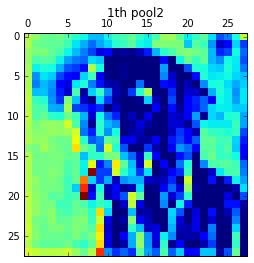

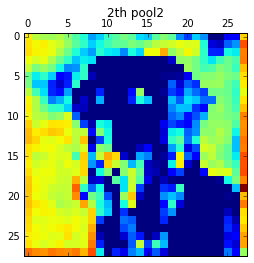

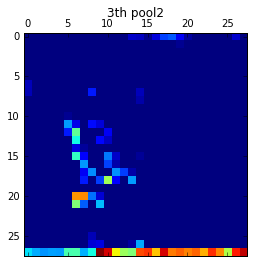

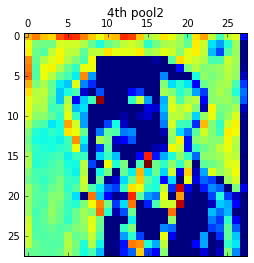

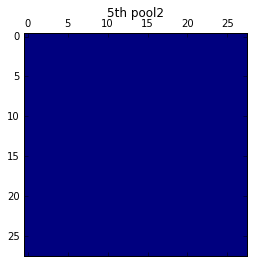

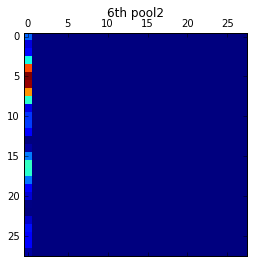

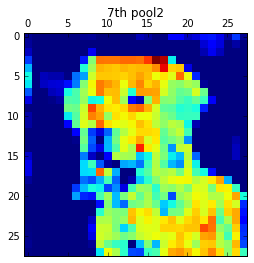

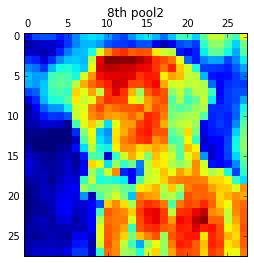

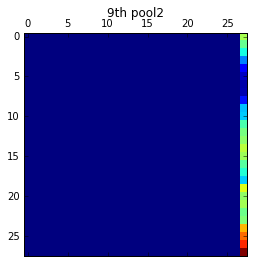

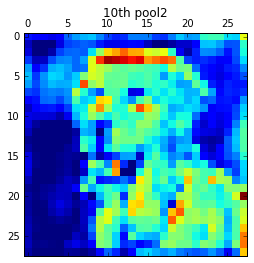

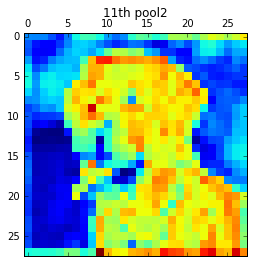

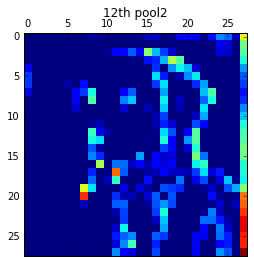

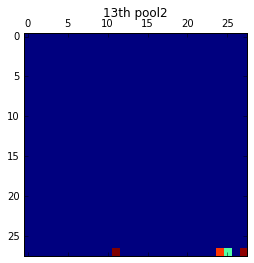

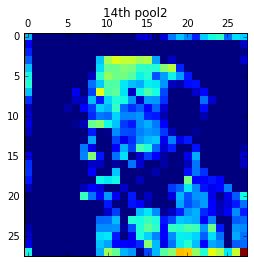

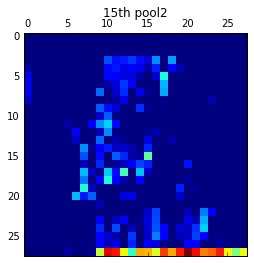

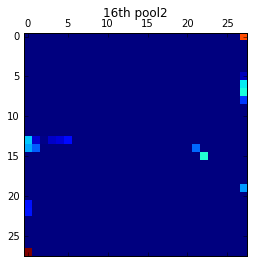

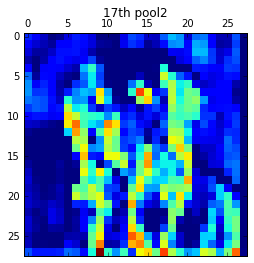

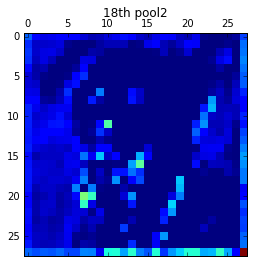

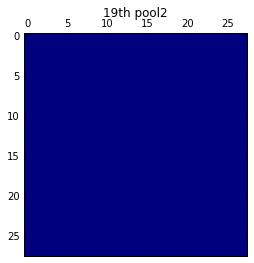

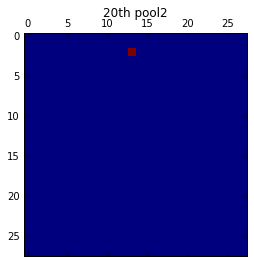

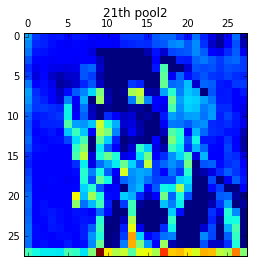

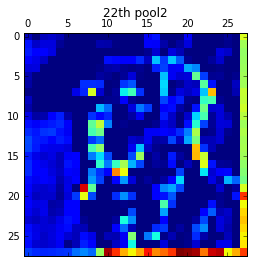

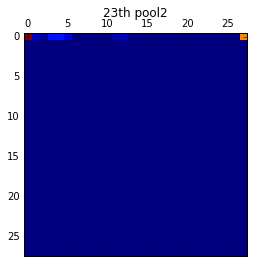

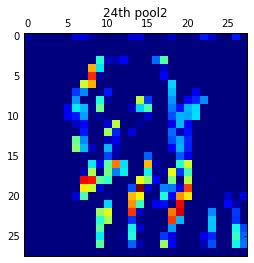

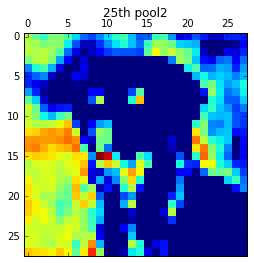

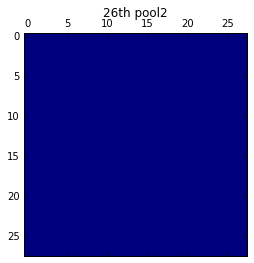

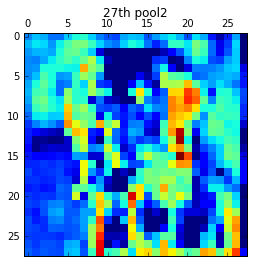

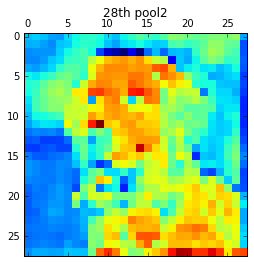

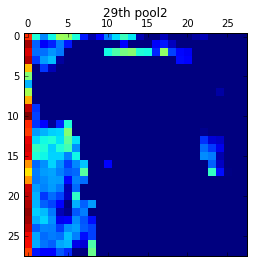

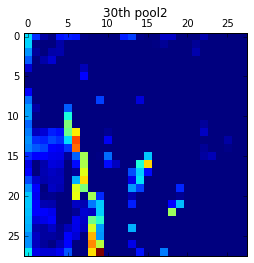

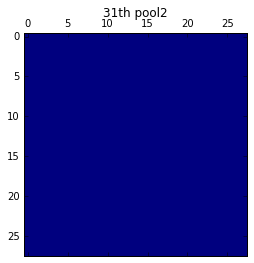

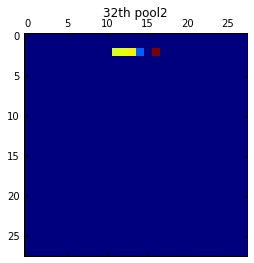

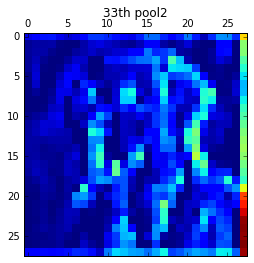

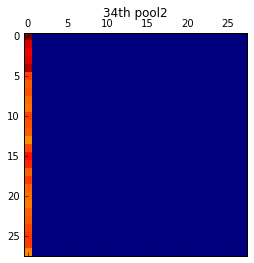

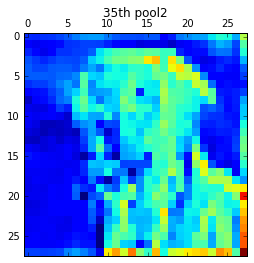

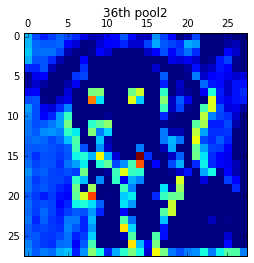

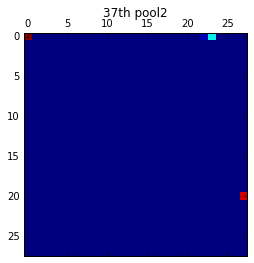

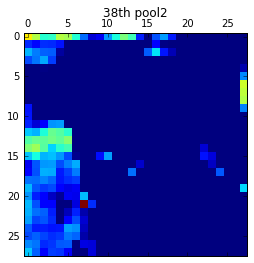

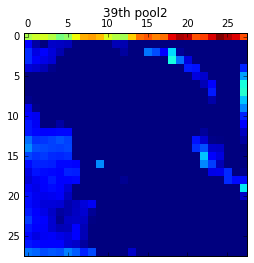

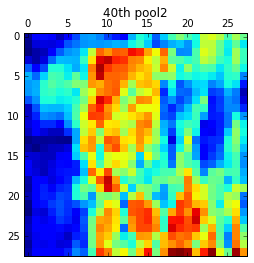

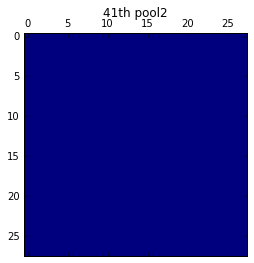

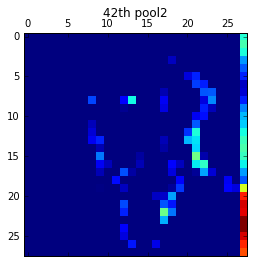

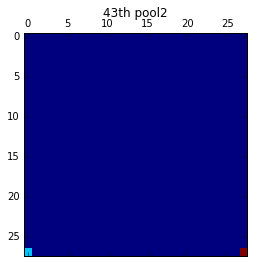

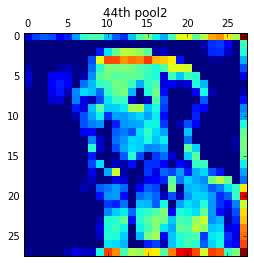

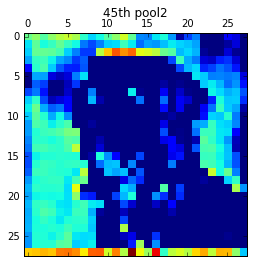

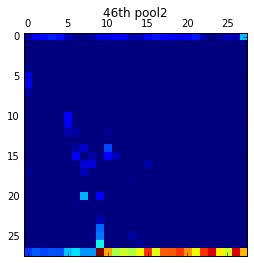

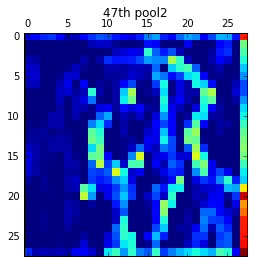

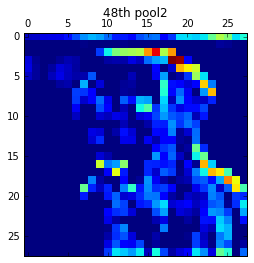

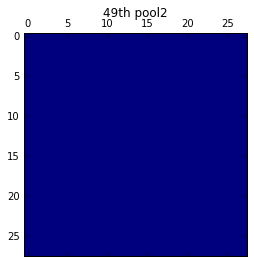

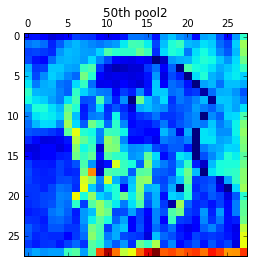

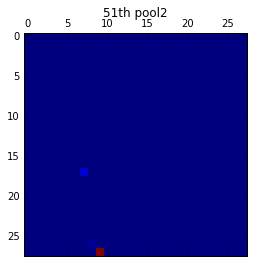

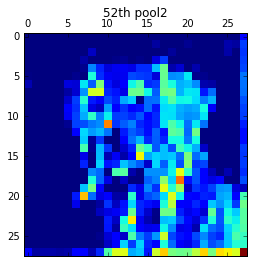

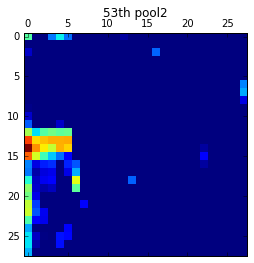

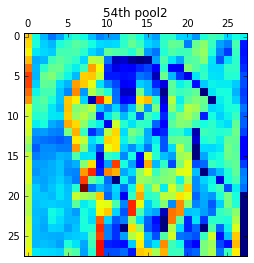

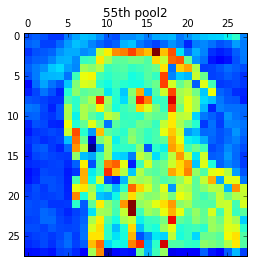

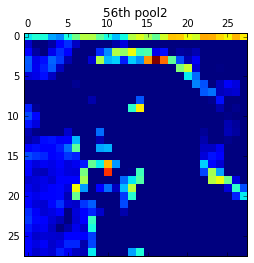

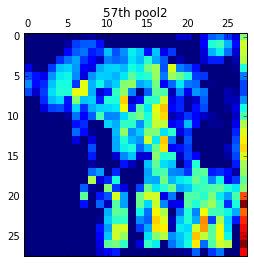

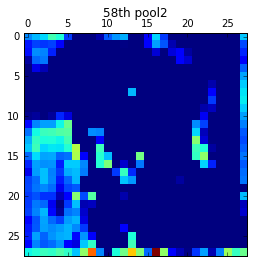

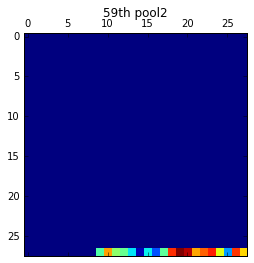

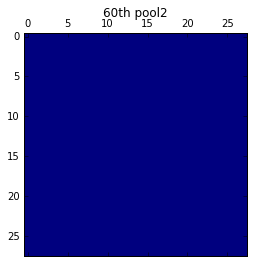

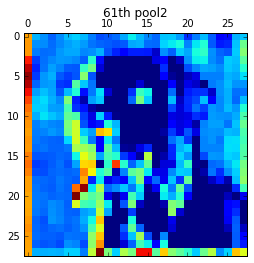

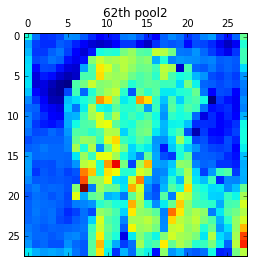

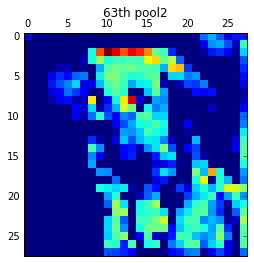

In [26]:
# Plot ! 
for i in range(64):
    plt.matshow(pool2_out[0, :, :, i])
    plt.title(str(i) + "th pool2")
    plt.show() 